# Install Required Libraries

In [1]:
!pip install transformers[torch] datasets seqeval accelerate -U


In [60]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, DistilBertForTokenClassification
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from seqeval.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Load Dataset

In [3]:
# Load a subset of the Universal Dependencies dataset for inspection
dataset = load_dataset("universal_dependencies", "en_gum")


In [4]:
# Print the column names for the training set
print(dataset['train'].column_names)
# Convert the 'train' split of your dataset to a Pandas DataFrame
train_df = dataset['train'].to_pandas()
print(train_df.head())
print(len(train_df))

['idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc']
                  idx                                               text  \
0  GUM_academic_art-1            Aesthetic Appreciation and Spanish Art:   
1  GUM_academic_art-2                         Insights from Eye-Tracking   
2  GUM_academic_art-3  Claire Bailey-Ross claire.bailey-ross@port.ac....   
3  GUM_academic_art-4  Andrew Beresford a.m.beresford@durham.ac.uk Du...   
4  GUM_academic_art-5  Daniel Smith daniel.smith2@durham.ac.uk Durham...   

                                              tokens  \
0    [Aesthetic, Appreciation, and, Spanish, Art, :]   
1                     [Insights, from, Eye-Tracking]   
2  [Claire, Bailey-Ross, claire.bailey-ross@port....   
3  [Andrew, Beresford, a.m.beresford@durham.ac.uk...   
4  [Daniel, Smith, daniel.smith2@durham.ac.uk, Du...   

                                              lemmas  \
0    [aesthetic, appreciation, and, Spanish, art, :]   

# Tokenize Dataset

In [5]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-multilingual-cased')

tokenizer_config.json: 100%|██████████| 29.0/29.0 [00:00<00:00, 29.0kB/s]
c:\Users\dell g3\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\dell g3\.cache\huggingface\hub\models--distilbert-base-multilingual-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message

In [6]:
unique_pos_tags = set()

# Aggregate unique POS tags from all dataset splits
for split in ['train', 'validation', 'test']:
    for example in dataset[split]:
        unique_pos_tags.update(example['upos'])

# Now that you have all unique POS tags, create the pos_tag2id and id2pos_tag dictionaries
pos_tag2id = {tag: idx for idx, tag in enumerate(unique_pos_tags)}
id2pos_tag = {idx: tag for tag, idx in pos_tag2id.items()}


In [7]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, padding="max_length", is_split_into_words=True, max_length=128)

    labels = [[] for _ in range(len(examples["tokens"]))]  # Initialize labels list for each example
    for i, label_sequence in enumerate(examples["upos"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Maps tokens to their word
        label_ids = [-100] * len(word_ids)  # Initialize all labels to ignore index

        previous_word_idx = None
        label_index = 0
        for word_idx in word_ids:
            if word_idx is not None and word_idx != previous_word_idx and label_index < len(label_sequence):
                label_id = pos_tag2id.get(label_sequence[label_index])  # Use .get() to avoid KeyError
                if label_id is not None:  # Check if the label_id exists
                    label_ids[word_idx] = label_id
                label_index += 1
            previous_word_idx = word_idx
        labels[i] = label_ids
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [8]:
tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True, remove_columns=dataset['train'].column_names)
print(tokenized_datasets)
tokenized_datasets['train']
tokenized_datasets_df = tokenized_datasets['train'].to_pandas()
print(tokenized_datasets_df.head())
print(len(tokenized_datasets_df))

Map:   0%|          | 0/4287 [00:00<?, ? examples/s]

Map: 100%|██████████| 890/890 [00:00<00:00, 5254.32 examples/s]


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 4287
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 784
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 890
    })
})
                                           input_ids  \
0  [101, 138, 13051, 13358, 11130, 73784, 74755, ...   
1  [101, 61862, 10107, 10188, 28577, 118, 26403, ...   
2  [101, 24448, 29761, 118, 16690, 103500, 10112,...   
3  [101, 13999, 40575, 62198, 169, 119, 181, 119,...   
4  [101, 11792, 11673, 10215, 19428, 119, 39709, ...   

                                      attention_mask  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...   
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...   
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
4  [1, 1, 1, 1, 1, 1, 1, 1, 

# Reduce the Dataset Size?

Given the objective to explore the impact of partial layer freezing on POS tagging performance, starting with a reduced dataset can help quickly gauge the feasibility and potential direction of the research. Once promising configurations are identified,the task can be scaled up to the full dataset to fine-tune and validate the findings.

*   **Shuffling**: The datasets are shuffled before reduction to ensure that the reduced dataset is a representative random sample of the original. This is important for maintaining the diversity of examples in smaller datasets.
    
*   **Seed for Reproducibility**: The `seed=42` parameter in the `.shuffle()` method ensures that the shuffling process is reproducible, meaning you'll get the same reduced dataset if you run the code multiple times.
    
*   **Adjusting Reduction Percentage**: You can modify `reduced_percentage` to any value between 0 and 1 (exclusive) depending on how much you want to reduce the dataset by. A value of `0.5` reduces the dataset to half its original size, while `0.1` would reduce it to 10%, and so on.

In [9]:
from datasets import DatasetDict

reduced_percentage = 0.1  # Target percentage to reduce each dataset to

# Function to reduce dataset size by a specified percentage
def reduce_dataset_size(dataset, percentage):
    # Calculate the number of samples to select based on the reduction percentage
    num_samples = int(len(dataset) * percentage)
    # Shuffle the dataset (with a fixed seed for reproducibility) and select the first num_samples
    reduced_dataset = dataset.shuffle(seed=42).select(range(num_samples))
    return reduced_dataset

# Reduce the size of the training, validation, and test datasets
reduced_train_dataset = reduce_dataset_size(tokenized_datasets['train'], reduced_percentage)
reduced_validation_dataset = reduce_dataset_size(tokenized_datasets['validation'], reduced_percentage)
reduced_test_dataset = reduce_dataset_size(tokenized_datasets['test'], reduced_percentage)

# Create a new DatasetDict with the reduced datasets
reduced_tokenized_datasets = DatasetDict({
    'train': reduced_train_dataset,
    'validation': reduced_validation_dataset,
    'test': reduced_test_dataset
})

# Now, you can proceed with training and evaluation using `reduced_tokenized_datasets`
reduced_tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 428
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 78
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 89
    })
})

# Define the Compute Metrics

In [48]:
def compute_metrics(p):
    predictions, labels = p
    # Flatten both the predictions and labels for evaluation
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [id2pos_tag[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    true_labels = [
        [id2pos_tag[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    # Flatten the lists
    true_predictions = [p for sublist in true_predictions for p in sublist]
    true_labels = [l for sublist in true_labels for l in sublist]

    # Calculate metrics
    accuracy = accuracy_score(true_labels, true_predictions)

    return {'accuracy': accuracy}


# Baseline Model Training

In [12]:
# Assuming pos_tag2id has been defined based on your dataset's unique POS tags
num_labels = len(pos_tag2id)

model_baseline = DistilBertForTokenClassification.from_pretrained(
    'distilbert-base-multilingual-cased',
    num_labels=num_labels
)

training_args_baseline = TrainingArguments(
    output_dir='./baseline_results',
    num_train_epochs=3,
    per_device_train_batch_size=128,  # Updated batch size
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer_baseline = Trainer(
    model=model_baseline,
    args=training_args_baseline,
    train_dataset=reduced_tokenized_datasets['train'],
    eval_dataset=reduced_tokenized_datasets['validation'],
    compute_metrics=compute_metrics  # Ensure this function computes accuracy, precision, recall, and F1
)

# Train the baseline model
trainer_baseline.train()

# Save the baseline model
trainer_baseline.save_model("./baseline_model")


model.safetensors: 100%|██████████| 542M/542M [01:04<00:00, 8.35MB/s] 
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 33%|███▎      | 4/12 [01:45<03:08, 23.56s/it]

{'loss': 2.7127, 'grad_norm': 1.5092084407806396, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}


                                              
 33%|███▎      | 4/12 [01:53<03:08, 23.56s/it] 

{'eval_loss': 2.534414291381836, 'eval_precision': 0.040135669869983036, 'eval_recall': 0.06133902329359544, 'eval_f1': 0.023910133503189653, 'eval_accuracy': 0.19053051911009697, 'eval_runtime': 7.6576, 'eval_samples_per_second': 10.186, 'eval_steps_per_second': 1.306, 'epoch': 1.0}


 67%|██████▋   | 8/12 [03:48<01:42, 25.67s/it]

{'loss': 2.4788, 'grad_norm': 1.0170406103134155, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}


                                              
 67%|██████▋   | 8/12 [03:55<01:42, 25.67s/it] 

{'eval_loss': 2.458814859390259, 'eval_precision': 0.03611142973498478, 'eval_recall': 0.06880594193542265, 'eval_f1': 0.03770750561567728, 'eval_accuracy': 0.2002281802624073, 'eval_runtime': 7.7464, 'eval_samples_per_second': 10.069, 'eval_steps_per_second': 1.291, 'epoch': 2.0}


100%|██████████| 12/12 [05:40<00:00, 24.14s/it]

{'loss': 2.4034, 'grad_norm': 1.0129964351654053, 'learning_rate': 0.0, 'epoch': 3.0}


                                               
100%|██████████| 12/12 [05:46<00:00, 24.14s/it]

{'eval_loss': 2.438114643096924, 'eval_precision': 0.0748533313937097, 'eval_recall': 0.073749851011053, 'eval_f1': 0.044792428413757863, 'eval_accuracy': 0.20365088419851682, 'eval_runtime': 6.6827, 'eval_samples_per_second': 11.672, 'eval_steps_per_second': 1.496, 'epoch': 3.0}


100%|██████████| 12/12 [05:56<00:00, 29.71s/it]


{'train_runtime': 356.5815, 'train_samples_per_second': 3.601, 'train_steps_per_second': 0.034, 'train_loss': 2.531620184580485, 'epoch': 3.0}


# Freezing Layers

In [31]:
def train_with_different_freezing_configs(freeze_configs, training_args, compute_metrics, train_dataset, eval_dataset, experiment_type):
    results = {}
    
    for config in freeze_configs:
        model_adjusted = initialize_and_freeze_model(layers_to_freeze=config)
        
        trainer = Trainer(
            model=model_adjusted,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            compute_metrics=compute_metrics
        )

        # Use experiment_type in the config_name to differentiate between single and compound freezing
        config_name = f"{experiment_type}_{'_'.join(str(x) for x in config)}"  # Include experiment type in the name
        print(f"Training with layers {config} frozen... [{experiment_type}]")
        trainer.train()

        # Evaluate the model on the validation set
        eval_results = trainer.evaluate()
        results[config_name] = eval_results

        # Save the model for each configuration with a unique name indicating the experiment type
        model_save_path = f"./models/{config_name}_frozen"
        model_adjusted.save_pretrained(model_save_path)
        
        # Optionally, save the Trainer state as well
        trainer.save_state()

    return results

## Single Layer Partial Freezing (SLPF)

In [32]:
# Single layer freezing configurations
freeze_configs_single = [[i] for i in range(6)]
experiment_results_single = train_with_different_freezing_configs(
    freeze_configs=freeze_configs_single,
    training_args=training_args_baseline,
    compute_metrics=compute_metrics,
    train_dataset=reduced_tokenized_datasets['train'],
    eval_dataset=reduced_tokenized_datasets['validation'],
    experiment_type='single'  # Indicate this is a single layer freezing experiment
)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training with layers [0] frozen... [single]


 33%|███▎      | 4/12 [01:36<02:55, 21.90s/it]

{'loss': 2.7297, 'grad_norm': 1.7510906457901, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}



 33%|███▎      | 4/12 [01:44<02:55, 21.90s/it] Checkpoint destination directory ./baseline_results\checkpoint-4 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.560823678970337, 'eval_precision': 0.03878955356111474, 'eval_recall': 0.06206375645122339, 'eval_f1': 0.02943539468689106, 'eval_accuracy': 0.18596691386195094, 'eval_runtime': 7.7637, 'eval_samples_per_second': 10.047, 'eval_steps_per_second': 1.288, 'epoch': 1.0}


 67%|██████▋   | 8/12 [03:28<01:33, 23.32s/it]

{'loss': 2.486, 'grad_norm': 1.126621961593628, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}



 67%|██████▋   | 8/12 [03:35<01:33, 23.32s/it] Checkpoint destination directory ./baseline_results\checkpoint-8 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.4667208194732666, 'eval_precision': 0.04910810549404907, 'eval_recall': 0.06612855168816695, 'eval_f1': 0.03264206272012292, 'eval_accuracy': 0.19737592698231604, 'eval_runtime': 7.3972, 'eval_samples_per_second': 10.545, 'eval_steps_per_second': 1.352, 'epoch': 2.0}


100%|██████████| 12/12 [05:21<00:00, 23.95s/it]

{'loss': 2.4076, 'grad_norm': 1.1685328483581543, 'learning_rate': 0.0, 'epoch': 3.0}



100%|██████████| 12/12 [05:28<00:00, 23.95s/it]Checkpoint destination directory ./baseline_results\checkpoint-12 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.442140579223633, 'eval_precision': 0.042927739799558114, 'eval_recall': 0.06961719190205856, 'eval_f1': 0.039817145428063756, 'eval_accuracy': 0.20079863091842556, 'eval_runtime': 7.2994, 'eval_samples_per_second': 10.686, 'eval_steps_per_second': 1.37, 'epoch': 3.0}


100%|██████████| 12/12 [05:35<00:00, 27.94s/it]


{'train_runtime': 335.298, 'train_samples_per_second': 3.829, 'train_steps_per_second': 0.036, 'train_loss': 2.5410998662312827, 'epoch': 3.0}


100%|██████████| 10/10 [00:06<00:00,  1.61it/s]
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training with layers [1] frozen... [single]


 33%|███▎      | 4/12 [01:35<02:49, 21.19s/it]

{'loss': 2.6793, 'grad_norm': 1.406329870223999, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}



 33%|███▎      | 4/12 [01:42<02:49, 21.19s/it] Checkpoint destination directory ./baseline_results\checkpoint-4 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.5295908451080322, 'eval_precision': 0.1310754481971462, 'eval_recall': 0.0650695446825298, 'eval_f1': 0.03390724843433381, 'eval_accuracy': 0.18996006845407873, 'eval_runtime': 7.2407, 'eval_samples_per_second': 10.772, 'eval_steps_per_second': 1.381, 'epoch': 1.0}


 67%|██████▋   | 8/12 [03:27<01:33, 23.29s/it]

{'loss': 2.4813, 'grad_norm': 1.1120176315307617, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}



 67%|██████▋   | 8/12 [03:34<01:33, 23.29s/it] Checkpoint destination directory ./baseline_results\checkpoint-8 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.452863931655884, 'eval_precision': 0.0782504493875452, 'eval_recall': 0.06807801086739919, 'eval_f1': 0.037561435019793435, 'eval_accuracy': 0.19851682829435255, 'eval_runtime': 7.2576, 'eval_samples_per_second': 10.747, 'eval_steps_per_second': 1.378, 'epoch': 2.0}


100%|██████████| 12/12 [05:23<00:00, 24.86s/it]

{'loss': 2.4067, 'grad_norm': 1.0868549346923828, 'learning_rate': 0.0, 'epoch': 3.0}



100%|██████████| 12/12 [05:30<00:00, 24.86s/it]Checkpoint destination directory ./baseline_results\checkpoint-12 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.4301416873931885, 'eval_precision': 0.1399693737223259, 'eval_recall': 0.07399720683270684, 'eval_f1': 0.04645119465420963, 'eval_accuracy': 0.2065031374786081, 'eval_runtime': 7.6148, 'eval_samples_per_second': 10.243, 'eval_steps_per_second': 1.313, 'epoch': 3.0}


100%|██████████| 12/12 [05:37<00:00, 28.10s/it]


{'train_runtime': 337.1572, 'train_samples_per_second': 3.808, 'train_steps_per_second': 0.036, 'train_loss': 2.5224482218424478, 'epoch': 3.0}


100%|██████████| 10/10 [00:06<00:00,  1.63it/s]
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training with layers [2] frozen... [single]


 33%|███▎      | 4/12 [01:42<03:03, 22.92s/it]

{'loss': 2.6806, 'grad_norm': 1.3954976797103882, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}



 33%|███▎      | 4/12 [01:50<03:03, 22.92s/it] Checkpoint destination directory ./baseline_results\checkpoint-4 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.530988931655884, 'eval_precision': 0.13668755903615365, 'eval_recall': 0.06513510282067868, 'eval_f1': 0.0346058785000246, 'eval_accuracy': 0.18996006845407873, 'eval_runtime': 7.649, 'eval_samples_per_second': 10.197, 'eval_steps_per_second': 1.307, 'epoch': 1.0}


 67%|██████▋   | 8/12 [03:43<01:41, 25.26s/it]

{'loss': 2.4845, 'grad_norm': 1.0913156270980835, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}



 67%|██████▋   | 8/12 [03:51<01:41, 25.26s/it] Checkpoint destination directory ./baseline_results\checkpoint-8 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.454779624938965, 'eval_precision': 0.0866346863785585, 'eval_recall': 0.06950498922410006, 'eval_f1': 0.03936743961114502, 'eval_accuracy': 0.20193953223046207, 'eval_runtime': 7.8051, 'eval_samples_per_second': 9.993, 'eval_steps_per_second': 1.281, 'epoch': 2.0}


100%|██████████| 12/12 [05:40<00:00, 24.86s/it]

{'loss': 2.4115, 'grad_norm': 1.0718134641647339, 'learning_rate': 0.0, 'epoch': 3.0}



100%|██████████| 12/12 [05:48<00:00, 24.86s/it]Checkpoint destination directory ./baseline_results\checkpoint-12 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.432299852371216, 'eval_precision': 0.13491636685116043, 'eval_recall': 0.07336791015478285, 'eval_f1': 0.04587170480522636, 'eval_accuracy': 0.20593268682258983, 'eval_runtime': 8.529, 'eval_samples_per_second': 9.145, 'eval_steps_per_second': 1.172, 'epoch': 3.0}


100%|██████████| 12/12 [05:54<00:00, 29.57s/it]


{'train_runtime': 354.9256, 'train_samples_per_second': 3.618, 'train_steps_per_second': 0.034, 'train_loss': 2.5255324045817056, 'epoch': 3.0}


100%|██████████| 10/10 [00:06<00:00,  1.57it/s]
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training with layers [3] frozen... [single]


 33%|███▎      | 4/12 [01:40<03:00, 22.55s/it]

{'loss': 2.686, 'grad_norm': 1.3894132375717163, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}



 33%|███▎      | 4/12 [01:48<03:00, 22.55s/it] Checkpoint destination directory ./baseline_results\checkpoint-4 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.539482355117798, 'eval_precision': 0.14088447747437058, 'eval_recall': 0.06659988771103595, 'eval_f1': 0.036582321534130165, 'eval_accuracy': 0.19224187107815174, 'eval_runtime': 7.6562, 'eval_samples_per_second': 10.188, 'eval_steps_per_second': 1.306, 'epoch': 1.0}


 67%|██████▋   | 8/12 [03:33<01:34, 23.69s/it]

{'loss': 2.4934, 'grad_norm': 1.0864250659942627, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}



 67%|██████▋   | 8/12 [03:41<01:34, 23.69s/it] Checkpoint destination directory ./baseline_results\checkpoint-8 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.462205648422241, 'eval_precision': 0.04773358489315119, 'eval_recall': 0.06691538386644404, 'eval_f1': 0.03464746174677349, 'eval_accuracy': 0.19794637763833428, 'eval_runtime': 7.197, 'eval_samples_per_second': 10.838, 'eval_steps_per_second': 1.389, 'epoch': 2.0}


100%|██████████| 12/12 [05:23<00:00, 23.43s/it]

{'loss': 2.4209, 'grad_norm': 1.0424144268035889, 'learning_rate': 0.0, 'epoch': 3.0}



100%|██████████| 12/12 [05:31<00:00, 23.43s/it]Checkpoint destination directory ./baseline_results\checkpoint-12 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.4394278526306152, 'eval_precision': 0.07469976627014442, 'eval_recall': 0.0716199744034619, 'eval_f1': 0.04262728635095897, 'eval_accuracy': 0.20479178551055333, 'eval_runtime': 7.7968, 'eval_samples_per_second': 10.004, 'eval_steps_per_second': 1.283, 'epoch': 3.0}


100%|██████████| 12/12 [05:38<00:00, 28.23s/it]


{'train_runtime': 338.743, 'train_samples_per_second': 3.79, 'train_steps_per_second': 0.035, 'train_loss': 2.533446947733561, 'epoch': 3.0}


100%|██████████| 10/10 [00:06<00:00,  1.47it/s]
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training with layers [4] frozen... [single]


 33%|███▎      | 4/12 [01:45<03:08, 23.58s/it]

{'loss': 2.6942, 'grad_norm': 1.4577598571777344, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}



 33%|███▎      | 4/12 [01:53<03:08, 23.58s/it] Checkpoint destination directory ./baseline_results\checkpoint-4 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.5528147220611572, 'eval_precision': 0.08441098496591556, 'eval_recall': 0.06710279839436799, 'eval_f1': 0.03888596830740281, 'eval_accuracy': 0.19053051911009697, 'eval_runtime': 7.9717, 'eval_samples_per_second': 9.785, 'eval_steps_per_second': 1.254, 'epoch': 1.0}


 67%|██████▋   | 8/12 [03:44<01:39, 24.91s/it]

{'loss': 2.5024, 'grad_norm': 1.1083229780197144, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}



 67%|██████▋   | 8/12 [03:52<01:39, 24.91s/it] Checkpoint destination directory ./baseline_results\checkpoint-8 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.4702906608581543, 'eval_precision': 0.07598520559103739, 'eval_recall': 0.06691139487375546, 'eval_f1': 0.03507246102036904, 'eval_accuracy': 0.19737592698231604, 'eval_runtime': 8.1638, 'eval_samples_per_second': 9.554, 'eval_steps_per_second': 1.225, 'epoch': 2.0}


100%|██████████| 12/12 [05:44<00:00, 25.43s/it]

{'loss': 2.4275, 'grad_norm': 1.0407134294509888, 'learning_rate': 0.0, 'epoch': 3.0}



100%|██████████| 12/12 [05:54<00:00, 25.43s/it]Checkpoint destination directory ./baseline_results\checkpoint-12 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.4465677738189697, 'eval_precision': 0.09011749795439183, 'eval_recall': 0.07060823948080808, 'eval_f1': 0.0410524123628338, 'eval_accuracy': 0.20308043354249858, 'eval_runtime': 9.6613, 'eval_samples_per_second': 8.073, 'eval_steps_per_second': 1.035, 'epoch': 3.0}


100%|██████████| 12/12 [06:01<00:00, 30.13s/it]


{'train_runtime': 361.5201, 'train_samples_per_second': 3.552, 'train_steps_per_second': 0.033, 'train_loss': 2.54136331876119, 'epoch': 3.0}


100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training with layers [5] frozen... [single]


 33%|███▎      | 4/12 [01:42<03:02, 22.84s/it]

{'loss': 2.7037, 'grad_norm': 1.4844751358032227, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}



 33%|███▎      | 4/12 [01:50<03:02, 22.84s/it] Checkpoint destination directory ./baseline_results\checkpoint-4 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.568437337875366, 'eval_precision': 0.06718015262934664, 'eval_recall': 0.06537783068351506, 'eval_f1': 0.03798008182777517, 'eval_accuracy': 0.18482601254991443, 'eval_runtime': 7.4982, 'eval_samples_per_second': 10.403, 'eval_steps_per_second': 1.334, 'epoch': 1.0}


 67%|██████▋   | 8/12 [03:37<01:36, 24.18s/it]

{'loss': 2.5214, 'grad_norm': 1.1626477241516113, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}



 67%|██████▋   | 8/12 [03:46<01:36, 24.18s/it] Checkpoint destination directory ./baseline_results\checkpoint-8 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.4828951358795166, 'eval_precision': 0.11921365001681092, 'eval_recall': 0.06542066639333632, 'eval_f1': 0.03236266107315, 'eval_accuracy': 0.195094124358243, 'eval_runtime': 8.2439, 'eval_samples_per_second': 9.462, 'eval_steps_per_second': 1.213, 'epoch': 2.0}


100%|██████████| 12/12 [05:36<00:00, 25.26s/it]

{'loss': 2.4461, 'grad_norm': 1.0345983505249023, 'learning_rate': 0.0, 'epoch': 3.0}



100%|██████████| 12/12 [05:45<00:00, 25.26s/it]Checkpoint destination directory ./baseline_results\checkpoint-12 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.458721160888672, 'eval_precision': 0.12024176131882251, 'eval_recall': 0.06655432377534415, 'eval_f1': 0.03461575654827761, 'eval_accuracy': 0.19737592698231604, 'eval_runtime': 8.6098, 'eval_samples_per_second': 9.059, 'eval_steps_per_second': 1.161, 'epoch': 3.0}


100%|██████████| 12/12 [05:52<00:00, 29.34s/it]


{'train_runtime': 352.1319, 'train_samples_per_second': 3.646, 'train_steps_per_second': 0.034, 'train_loss': 2.55706795056661, 'epoch': 3.0}


100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


## Compound Layer Partial Freezing (CLPF)

In [36]:
# Compound layer freezing configurations (for comparison or as previously defined)
freeze_configs_compound = [
    [0], [0, 1], [0, 1, 2], [0, 1, 2, 3], [0, 1, 2, 3, 4], [0, 1, 2, 3, 4, 5]
]
experiment_results_compound = train_with_different_freezing_configs(
    freeze_configs=freeze_configs_compound,
    training_args=training_args_baseline,
    compute_metrics=compute_metrics,
    train_dataset=reduced_tokenized_datasets['train'],
    eval_dataset=reduced_tokenized_datasets['validation'],
    experiment_type='compound'  # Indicate this is a compound layer freezing experiment
)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/12 [02:43<?, ?it/s]


Training with layers [0] frozen... [compound]


 33%|███▎      | 4/12 [01:39<03:01, 22.65s/it]

{'loss': 2.6783, 'grad_norm': 1.4383883476257324, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}



 33%|███▎      | 4/12 [01:48<03:01, 22.65s/it] Checkpoint destination directory ./baseline_results\checkpoint-4 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.5235342979431152, 'eval_precision': 0.035797717690168644, 'eval_recall': 0.06202066650933357, 'eval_f1': 0.03010380049909595, 'eval_accuracy': 0.1802624073017684, 'eval_runtime': 8.2352, 'eval_samples_per_second': 9.472, 'eval_steps_per_second': 1.214, 'epoch': 1.0}


 67%|██████▋   | 8/12 [03:39<01:40, 25.19s/it]

{'loss': 2.4713, 'grad_norm': 1.073571801185608, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}



 67%|██████▋   | 8/12 [03:48<01:40, 25.19s/it] Checkpoint destination directory ./baseline_results\checkpoint-8 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.4509966373443604, 'eval_precision': 0.0649364592166358, 'eval_recall': 0.06634842197005028, 'eval_f1': 0.03564680254559683, 'eval_accuracy': 0.1939532230462065, 'eval_runtime': 8.6687, 'eval_samples_per_second': 8.998, 'eval_steps_per_second': 1.154, 'epoch': 2.0}


100%|██████████| 12/12 [05:33<00:00, 24.27s/it]

{'loss': 2.4097, 'grad_norm': 1.1367559432983398, 'learning_rate': 0.0, 'epoch': 3.0}



100%|██████████| 12/12 [05:40<00:00, 24.27s/it]Checkpoint destination directory ./baseline_results\checkpoint-12 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.428342342376709, 'eval_precision': 0.07317835189381558, 'eval_recall': 0.07765072729790823, 'eval_f1': 0.05410168923320529, 'eval_accuracy': 0.20992584141471762, 'eval_runtime': 7.405, 'eval_samples_per_second': 10.533, 'eval_steps_per_second': 1.35, 'epoch': 3.0}


100%|██████████| 12/12 [05:47<00:00, 28.99s/it]


{'train_runtime': 347.765, 'train_samples_per_second': 3.692, 'train_steps_per_second': 0.035, 'train_loss': 2.519769032796224, 'epoch': 3.0}


100%|██████████| 10/10 [00:06<00:00,  1.52it/s]
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training with layers [0, 1] frozen... [compound]


 33%|███▎      | 4/12 [01:33<02:48, 21.01s/it]

{'loss': 2.6893, 'grad_norm': 1.4679749011993408, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}



 33%|███▎      | 4/12 [01:41<02:48, 21.01s/it] Checkpoint destination directory ./baseline_results\checkpoint-4 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.54581356048584, 'eval_precision': 0.11086207639849797, 'eval_recall': 0.0651563655168822, 'eval_f1': 0.03586913712262081, 'eval_accuracy': 0.1876782658300057, 'eval_runtime': 7.4171, 'eval_samples_per_second': 10.516, 'eval_steps_per_second': 1.348, 'epoch': 1.0}


 67%|██████▋   | 8/12 [03:21<01:29, 22.46s/it]

{'loss': 2.4983, 'grad_norm': 1.134790062904358, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}



 67%|██████▋   | 8/12 [03:29<01:29, 22.46s/it] Checkpoint destination directory ./baseline_results\checkpoint-8 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.467076063156128, 'eval_precision': 0.07514311406303598, 'eval_recall': 0.06643429871721543, 'eval_f1': 0.035471896789406925, 'eval_accuracy': 0.195094124358243, 'eval_runtime': 7.7018, 'eval_samples_per_second': 10.127, 'eval_steps_per_second': 1.298, 'epoch': 2.0}


100%|██████████| 12/12 [05:08<00:00, 22.63s/it]

{'loss': 2.4244, 'grad_norm': 1.085565447807312, 'learning_rate': 0.0, 'epoch': 3.0}



100%|██████████| 12/12 [05:16<00:00, 22.63s/it]Checkpoint destination directory ./baseline_results\checkpoint-12 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.4438469409942627, 'eval_precision': 0.08206694541753544, 'eval_recall': 0.07173085503249432, 'eval_f1': 0.04283320928335669, 'eval_accuracy': 0.20422133485453509, 'eval_runtime': 7.2599, 'eval_samples_per_second': 10.744, 'eval_steps_per_second': 1.377, 'epoch': 3.0}


100%|██████████| 12/12 [05:23<00:00, 26.99s/it]


{'train_runtime': 323.9382, 'train_samples_per_second': 3.964, 'train_steps_per_second': 0.037, 'train_loss': 2.5373409589131675, 'epoch': 3.0}


100%|██████████| 10/10 [00:06<00:00,  1.53it/s]
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training with layers [0, 1, 2] frozen... [compound]


 33%|███▎      | 4/12 [01:28<02:38, 19.87s/it]

{'loss': 2.703, 'grad_norm': 1.5147755146026611, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}



 33%|███▎      | 4/12 [01:36<02:38, 19.87s/it] Checkpoint destination directory ./baseline_results\checkpoint-4 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.5697734355926514, 'eval_precision': 0.07895034661380605, 'eval_recall': 0.06430688495333214, 'eval_f1': 0.03632615090725487, 'eval_accuracy': 0.18254420992584142, 'eval_runtime': 7.6792, 'eval_samples_per_second': 10.157, 'eval_steps_per_second': 1.302, 'epoch': 1.0}


 67%|██████▋   | 8/12 [03:19<01:30, 22.60s/it]

{'loss': 2.5266, 'grad_norm': 1.1499830484390259, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}



 67%|██████▋   | 8/12 [03:27<01:30, 22.60s/it] Checkpoint destination directory ./baseline_results\checkpoint-8 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.490589141845703, 'eval_precision': 0.07902833141322255, 'eval_recall': 0.0658252387780009, 'eval_f1': 0.034020858496463365, 'eval_accuracy': 0.19452367370222476, 'eval_runtime': 7.6723, 'eval_samples_per_second': 10.166, 'eval_steps_per_second': 1.303, 'epoch': 2.0}


100%|██████████| 12/12 [05:10<00:00, 23.09s/it]

{'loss': 2.4561, 'grad_norm': 1.0685828924179077, 'learning_rate': 0.0, 'epoch': 3.0}



100%|██████████| 12/12 [05:18<00:00, 23.09s/it]Checkpoint destination directory ./baseline_results\checkpoint-12 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.4677038192749023, 'eval_precision': 0.08159911112714624, 'eval_recall': 0.06940131594646343, 'eval_f1': 0.04000013715498752, 'eval_accuracy': 0.20079863091842556, 'eval_runtime': 8.0418, 'eval_samples_per_second': 9.699, 'eval_steps_per_second': 1.244, 'epoch': 3.0}


100%|██████████| 12/12 [05:25<00:00, 27.13s/it]


{'train_runtime': 325.5391, 'train_samples_per_second': 3.944, 'train_steps_per_second': 0.037, 'train_loss': 2.5619075298309326, 'epoch': 3.0}


100%|██████████| 10/10 [00:06<00:00,  1.57it/s]
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training with layers [0, 1, 2, 3] frozen... [compound]


 33%|███▎      | 4/12 [01:25<02:31, 18.99s/it]

{'loss': 2.7241, 'grad_norm': 1.5354557037353516, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}



 33%|███▎      | 4/12 [01:32<02:31, 18.99s/it] Checkpoint destination directory ./baseline_results\checkpoint-4 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.6096155643463135, 'eval_precision': 0.06839387889608711, 'eval_recall': 0.0638686212879426, 'eval_f1': 0.03857427531328569, 'eval_accuracy': 0.1762692527096406, 'eval_runtime': 7.3349, 'eval_samples_per_second': 10.634, 'eval_steps_per_second': 1.363, 'epoch': 1.0}


 67%|██████▋   | 8/12 [03:03<01:21, 20.40s/it]

{'loss': 2.5727, 'grad_norm': 1.2065348625183105, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}



 67%|██████▋   | 8/12 [03:11<01:21, 20.40s/it] Checkpoint destination directory ./baseline_results\checkpoint-8 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.5319695472717285, 'eval_precision': 0.10503247367940943, 'eval_recall': 0.06451434696603175, 'eval_f1': 0.03426126567959294, 'eval_accuracy': 0.18824871648602395, 'eval_runtime': 7.3925, 'eval_samples_per_second': 10.551, 'eval_steps_per_second': 1.353, 'epoch': 2.0}


100%|██████████| 12/12 [04:43<00:00, 20.82s/it]

{'loss': 2.5065, 'grad_norm': 1.0569182634353638, 'learning_rate': 0.0, 'epoch': 3.0}



100%|██████████| 12/12 [04:50<00:00, 20.82s/it]Checkpoint destination directory ./baseline_results\checkpoint-12 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.509274482727051, 'eval_precision': 0.07721477479045882, 'eval_recall': 0.06487504797200873, 'eval_f1': 0.034105689221429314, 'eval_accuracy': 0.19110096976611524, 'eval_runtime': 7.412, 'eval_samples_per_second': 10.523, 'eval_steps_per_second': 1.349, 'epoch': 3.0}


100%|██████████| 12/12 [04:58<00:00, 24.89s/it]


{'train_runtime': 298.6404, 'train_samples_per_second': 4.299, 'train_steps_per_second': 0.04, 'train_loss': 2.601102034250895, 'epoch': 3.0}


100%|██████████| 10/10 [00:06<00:00,  1.59it/s]
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training with layers [0, 1, 2, 3, 4] frozen... [compound]


 33%|███▎      | 4/12 [01:20<02:24, 18.07s/it]

{'loss': 2.7578, 'grad_norm': 1.575357437133789, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}



 33%|███▎      | 4/12 [01:28<02:24, 18.07s/it] Checkpoint destination directory ./baseline_results\checkpoint-4 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.6804754734039307, 'eval_precision': 0.042480789107086685, 'eval_recall': 0.057401126004423736, 'eval_f1': 0.03754052751561802, 'eval_accuracy': 0.1477467199087279, 'eval_runtime': 7.4579, 'eval_samples_per_second': 10.459, 'eval_steps_per_second': 1.341, 'epoch': 1.0}


 67%|██████▋   | 8/12 [02:55<01:18, 19.55s/it]

{'loss': 2.6535, 'grad_norm': 1.3938895463943481, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}



 67%|██████▋   | 8/12 [03:02<01:18, 19.55s/it] Checkpoint destination directory ./baseline_results\checkpoint-8 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.6170332431793213, 'eval_precision': 0.06300175955962121, 'eval_recall': 0.06329821429731708, 'eval_f1': 0.03924408276228973, 'eval_accuracy': 0.1728465487735311, 'eval_runtime': 7.5904, 'eval_samples_per_second': 10.276, 'eval_steps_per_second': 1.317, 'epoch': 2.0}


100%|██████████| 12/12 [04:29<00:00, 19.75s/it]

{'loss': 2.5975, 'grad_norm': 1.2356091737747192, 'learning_rate': 0.0, 'epoch': 3.0}



100%|██████████| 12/12 [04:37<00:00, 19.75s/it]Checkpoint destination directory ./baseline_results\checkpoint-12 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.596062183380127, 'eval_precision': 0.0727432466320088, 'eval_recall': 0.06353179944264006, 'eval_f1': 0.037999036486297925, 'eval_accuracy': 0.17741015402167712, 'eval_runtime': 7.5094, 'eval_samples_per_second': 10.387, 'eval_steps_per_second': 1.332, 'epoch': 3.0}


100%|██████████| 12/12 [04:44<00:00, 23.71s/it]


{'train_runtime': 284.5818, 'train_samples_per_second': 4.512, 'train_steps_per_second': 0.042, 'train_loss': 2.6695982615152993, 'epoch': 3.0}


100%|██████████| 10/10 [00:06<00:00,  1.54it/s]
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training with layers [0, 1, 2, 3, 4, 5] frozen... [compound]


 33%|███▎      | 4/12 [01:16<02:16, 17.09s/it]

{'loss': 2.808, 'grad_norm': 1.4173012971878052, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}



 33%|███▎      | 4/12 [01:23<02:16, 17.09s/it] Checkpoint destination directory ./baseline_results\checkpoint-4 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.7963616847991943, 'eval_precision': 0.06439936831267665, 'eval_recall': 0.07249836366003277, 'eval_f1': 0.05203079135225092, 'eval_accuracy': 0.10154021677124929, 'eval_runtime': 7.4715, 'eval_samples_per_second': 10.44, 'eval_steps_per_second': 1.338, 'epoch': 1.0}


 67%|██████▋   | 8/12 [02:47<01:14, 18.57s/it]

{'loss': 2.7968, 'grad_norm': 1.4311739206314087, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}



 67%|██████▋   | 8/12 [02:54<01:14, 18.57s/it] Checkpoint destination directory ./baseline_results\checkpoint-8 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.7853176593780518, 'eval_precision': 0.05971629058080164, 'eval_recall': 0.05523445425435447, 'eval_f1': 0.04807750393712648, 'eval_accuracy': 0.1026811180832858, 'eval_runtime': 7.4183, 'eval_samples_per_second': 10.515, 'eval_steps_per_second': 1.348, 'epoch': 2.0}


100%|██████████| 12/12 [04:17<00:00, 18.73s/it]

{'loss': 2.78, 'grad_norm': 1.4085187911987305, 'learning_rate': 0.0, 'epoch': 3.0}



100%|██████████| 12/12 [04:24<00:00, 18.73s/it]Checkpoint destination directory ./baseline_results\checkpoint-12 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 2.7811477184295654, 'eval_precision': 0.059052109226723166, 'eval_recall': 0.055645421560985155, 'eval_f1': 0.04795498754106676, 'eval_accuracy': 0.1038220193953223, 'eval_runtime': 7.425, 'eval_samples_per_second': 10.505, 'eval_steps_per_second': 1.347, 'epoch': 3.0}


100%|██████████| 12/12 [04:33<00:00, 22.76s/it]


{'train_runtime': 273.2188, 'train_samples_per_second': 4.7, 'train_steps_per_second': 0.044, 'train_loss': 2.7948994636535645, 'epoch': 3.0}


100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


# Model Evaluation on Test Set

## Baseline Model

In [37]:
# # Evaluate base models on the test set to compare performance
baseline_results = trainer_baseline.evaluate(tokenized_datasets['test'])

print("Baseline Model Performance:", baseline_results)


100%|██████████| 112/112 [01:22<00:00,  1.36it/s]

Baseline Model Performance: {'eval_loss': 2.386464834213257, 'eval_precision': 0.09407578285499864, 'eval_recall': 0.07821171108547773, 'eval_f1': 0.049397430715043884, 'eval_accuracy': 0.22077106618108752, 'eval_runtime': 83.4095, 'eval_samples_per_second': 10.67, 'eval_steps_per_second': 1.343, 'epoch': 3.0}


## SLPF and CLPF ModelS


In [38]:
def evaluate_models(model_type, layers, compute_metrics, test_dataset):
    results = {}
    
    for layer in layers:
        model_name = f"{model_type}_{layer}_frozen"
        model_path = f"./models/{model_name}"
        
        print(f"Evaluating {model_name}...")
        
        # Load the model from the specified path
        model = DistilBertForTokenClassification.from_pretrained(model_path, num_labels=num_labels)
        
        # Initialize the Trainer
        trainer = Trainer(
            model=model,
            args=TrainingArguments(
                output_dir="./eval_results",  # Temporary directory for evaluation artifacts
                per_device_eval_batch_size=8,  # Adjust as needed
            ),
            compute_metrics=compute_metrics,
        )
        
        # Evaluate the model on the test dataset
        eval_results = trainer.evaluate(test_dataset)
        
        # Store the results
        results[model_name] = eval_results
    
    return results

In [39]:
# Single layer configurations
single_layers = [str(i) for i in range(6)]

# Compound layer configurations
compound_layers = ['0', '0_1', '0_1_2', '0_1_2_3', '0_1_2_3_4', '0_1_2_3_4_5']


In [40]:
# Assuming compute_metrics and tokenized_datasets['test'] are defined

# Evaluate Single Layer Partial Freezing (SLPF) models
slpf_results = evaluate_models("single", single_layers, compute_metrics, tokenized_datasets['test'])

# Evaluate Compound Layer Partial Freezing (CLPF) models
clpf_results = evaluate_models("compound", compound_layers, compute_metrics, tokenized_datasets['test'])


Evaluating single_0_frozen...


100%|██████████| 112/112 [01:18<00:00,  1.43it/s]


Evaluating single_1_frozen...


100%|██████████| 112/112 [01:23<00:00,  1.34it/s]


Evaluating single_2_frozen...


100%|██████████| 112/112 [01:23<00:00,  1.34it/s]


Evaluating single_3_frozen...


100%|██████████| 112/112 [01:24<00:00,  1.33it/s]


Evaluating single_4_frozen...


100%|██████████| 112/112 [01:25<00:00,  1.31it/s]


Evaluating single_5_frozen...


100%|██████████| 112/112 [01:30<00:00,  1.24it/s]


Evaluating compound_0_frozen...


100%|██████████| 112/112 [01:29<00:00,  1.26it/s]


Evaluating compound_0_1_frozen...


100%|██████████| 112/112 [01:37<00:00,  1.15it/s]


Evaluating compound_0_1_2_frozen...


100%|██████████| 112/112 [01:36<00:00,  1.16it/s]


Evaluating compound_0_1_2_3_frozen...


100%|██████████| 112/112 [01:30<00:00,  1.24it/s]


Evaluating compound_0_1_2_3_4_frozen...


100%|██████████| 112/112 [01:32<00:00,  1.21it/s]


Evaluating compound_0_1_2_3_4_5_frozen...


100%|██████████| 112/112 [01:35<00:00,  1.17it/s]


# Visualizations

C:\Users\dell g3\AppData\Local\Temp\ipykernel_18556\4255083674.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(axs[0].get_yticks(), fontsize=12)
C:\Users\dell g3\AppData\Local\Temp\ipykernel_18556\4255083674.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(axs[1].get_yticks(), fontsize=12)


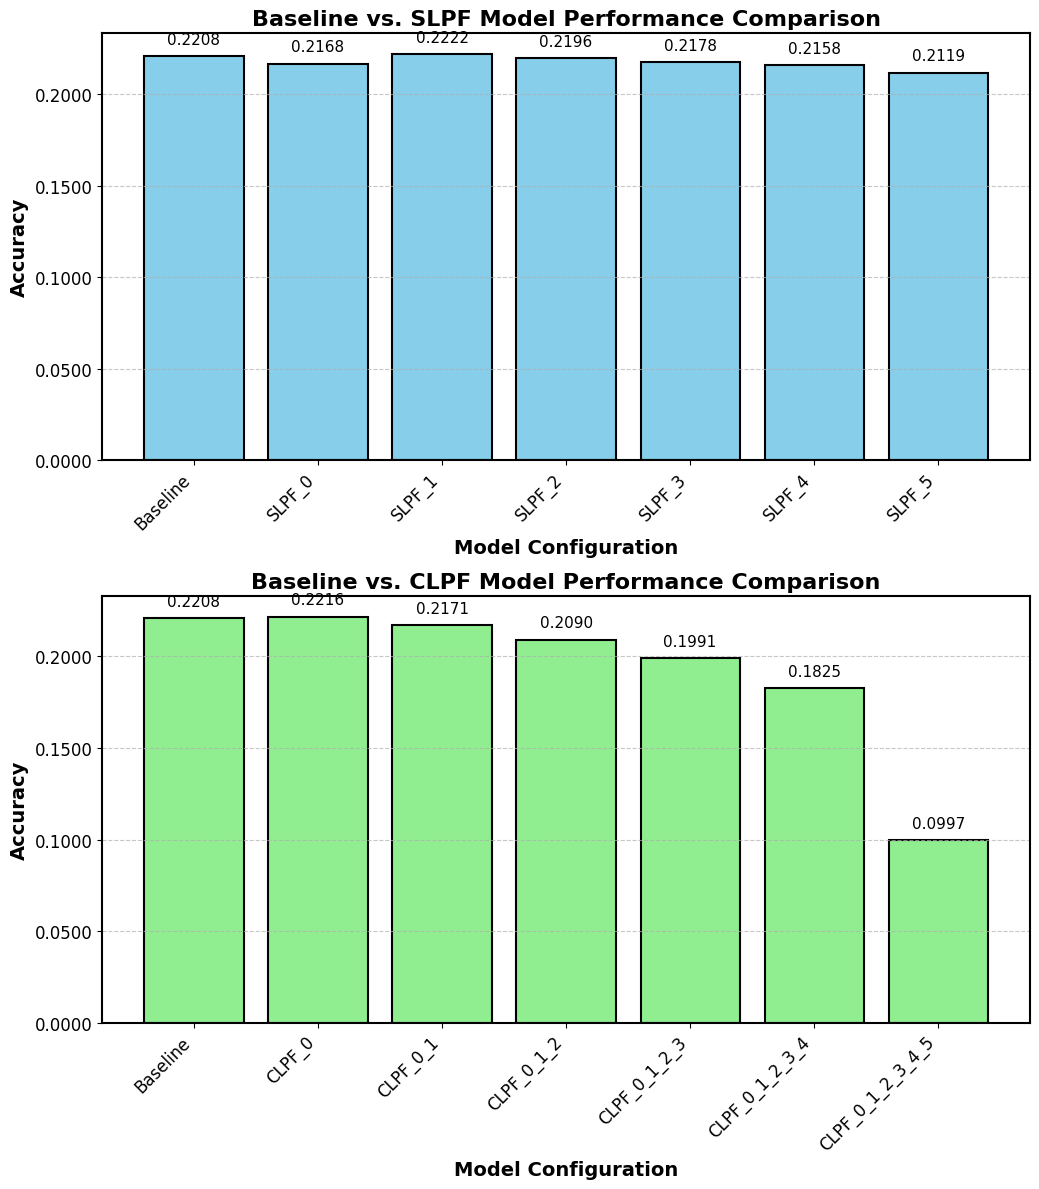

In [62]:
# Assuming baseline_results and both slpf_results & clpf_results are defined previously

# SLPF accuracies including the baseline for comparison
slpf_accuracies = [baseline_results['eval_accuracy']] + [slpf_results[f'single_{i}_frozen']['eval_accuracy'] for i in range(6)]
slpf_config_names = ['Baseline'] + [f'SLPF_{i}' for i in range(6)]

# CLPF accuracies including the baseline for comparison
clpf_accuracies = [baseline_results['eval_accuracy']] + [clpf_results[f'compound_{layer}_frozen']['eval_accuracy'] for layer in ['0', '0_1', '0_1_2', '0_1_2_3', '0_1_2_3_4', '0_1_2_3_4_5']]
clpf_config_names = ['Baseline'] + [f'CLPF_{layer}' for layer in ['0', '0_1', '0_1_2', '0_1_2_3', '0_1_2_3_4', '0_1_2_3_4_5']]

fig, axs = plt.subplots(2, 1, figsize=(max(8, len(slpf_config_names) * 1.5), 12))  # Adjusting for 2 subplots

# Formatter for the y-axis
formatter = mticker.FormatStrFormatter('%.4f')

# Plot for SLPF accuracies
bars1 = axs[0].bar(slpf_config_names, slpf_accuracies, color='skyblue', linewidth=1.5, edgecolor='black')
axs[0].set_xlabel('Model Configuration', fontsize=14, fontweight='bold')
axs[0].set_ylabel('Accuracy', fontsize=14, fontweight='bold')
axs[0].set_xticks(range(len(slpf_config_names)))
axs[0].set_xticklabels(slpf_config_names, rotation=45, ha="right", fontsize=12)
axs[0].set_yticklabels(axs[0].get_yticks(), fontsize=12)
axs[0].yaxis.set_major_formatter(formatter)  # Set the formatter for the y-axis
axs[0].set_title('Baseline vs. SLPF Model Performance Comparison', fontsize=16, fontweight='bold')

# Add grid and style the spines
axs[0].grid(axis='y', linestyle='--', alpha=0.7)
for spine in axs[0].spines.values():
    spine.set_linewidth(1.5)

# Add text labels on the bars
for bar in bars1:
    yval = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width()/2, yval + 0.005, f'{yval:.4f}', ha='center', va='bottom', fontsize=11)

# Plot for CLPF accuracies
bars2 = axs[1].bar(clpf_config_names, clpf_accuracies, color='lightgreen', linewidth=1.5, edgecolor='black')
axs[1].set_xlabel('Model Configuration', fontsize=14, fontweight='bold')
axs[1].set_ylabel('Accuracy', fontsize=14, fontweight='bold')
axs[1].set_xticks(range(len(clpf_config_names)))
axs[1].set_xticklabels(clpf_config_names, rotation=45, ha="right", fontsize=12)
axs[1].set_yticklabels(axs[1].get_yticks(), fontsize=12)
axs[1].yaxis.set_major_formatter(formatter)  # Set the formatter for the y-axis
axs[1].set_title('Baseline vs. CLPF Model Performance Comparison', fontsize=16, fontweight='bold')

# Add grid and style the spines
axs[1].grid(axis='y', linestyle='--', alpha=0.7)
for spine in axs[1].spines.values():
    spine.set_linewidth(1.5)

# Add text labels on the bars
for bar in bars2:
    yval = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width()/2, yval + 0.005, f'{yval:.4f}', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()
